## KQ3: Pritts Meta-analysis Update

In key question 3, we address the risk of sarcoma dissemination following morcellation of fibroids. We identified a recently published analysis conducted by Elizabeth Pritts and her colleagues (2015) to estimate the  prevalence of occult leiomyosarcoma at time of treatment for presumed benign tumors (fibroids).  We updated their search and used similar eligibility criteria to identify papers published since 2014. We extracted from these papers the number of women who were treated for uterine fibroids and the cases of leiomyosarcoma subsequently identified.  We have combined these data with the data from the 134 publications that Pritts et al included in their analysis for a total of LMS rates from 148 sources.

In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

rseeds = 20090425, 19771114

In [83]:
keep_cols = ['Author', 'Year', 'Design', 'Procedure', 'Indication',
                                     'Age, Mean', 'Age, SD', 'Age, Median', 'Age, Min', 'Age, Max', 'Age, Other',
                                     'LMS','Population','Tumors','InPritts','POSTOP_HP_Done', 'Hysteroscopy']

datasets = pd.read_excel('data/Pritts_EPC_KQ3_Includes_Histopathology_SK_12152016.xlsx', 
                         sheetname=['OLD_PRITTS', 'UPDATED_PRITTS', 'Updated_Pritts_With_EPC_INclude'], 
                         na_values=['NR', 'NA'],
                        index_col=0)

In [87]:
def clean_data(kq3_data):

    return (kq3_data.assign(age_max=kq3_data['Age, Max'].replace('50+', 50),
                           design=kq3_data['Design'].str.strip().replace('prospective', 'Prospective'),
                           Prospective=(kq3_data.Design!='Retrospective').astype(int))
                    .rename(columns={'Age, Min': 'age_min',
                                       'Age, Mean': 'age_mean',
                                       'Age, SD': 'age_sd',
                                       'Age, Median': 'age_med'})
                    .drop(['Age, Max', 'Design'], axis=1)
                    .dropna(thresh=7))
    

In [88]:
datasets = {sheet: clean_data(three_sheets[sheet][keep_cols]) for sheet in three_sheets}

old_pritts = datasets['OLD_PRITTS']
updated_pritts = datasets['UPDATED_PRITTS']
all_data = datasets['Updated_Pritts_With_EPC_INclude']

Missing values

In [89]:
all_data.isnull().sum()

Author              0
Year                0
Procedure           0
Indication          1
age_mean           72
age_sd            150
age_med           151
age_min            65
Age, Other        128
LMS                 0
Population          0
Tumors              0
InPritts            1
POSTOP_HP_Done      0
Hysteroscopy        0
Prospective         0
age_max            66
design              0
dtype: int64

In [90]:
all_data.describe()

,Year,age_mean,age_sd,age_med,age_min,LMS,Population,Tumors,InPritts,Prospective,age_max
count,162.000000,90.000000,12.000000,11.000000,97.00000,162.000000,162.000000,162.000000,161.000000,162.000000,96.000000
mean,2005.185185,41.919222,7.009167,41.545455,26.91134,2.500000,975.851852,2.500000,0.832298,0.419753,61.466667
std,7.858391,6.130203,2.821758,5.791954,6.20752,13.239903,3890.629500,13.239903,0.374767,0.495049,13.430732
min,1984.000000,28.200000,1.800000,35.000000,18.00000,0.000000,5.000000,0.000000,0.000000,0.000000,34.000000
25%,1999.000000,37.310000,5.925000,37.450000,22.00000,0.000000,40.250000,0.000000,1.000000,0.000000,51.000000
50%,2006.000000,42.200000,6.600000,40.000000,26.00000,0.000000,92.000000,0.000000,1.000000,0.000000,60.000000
75%,2012.000000,46.000000,7.697500,45.800000,31.00000,0.000000,359.500000,0.000000,1.000000,1.000000,70.250000
max,2016.000000,59.600000,12.500000,52.900000,44.00000,115.000000,34728.000000,115.000000,1.000000,1.000000,96.000000


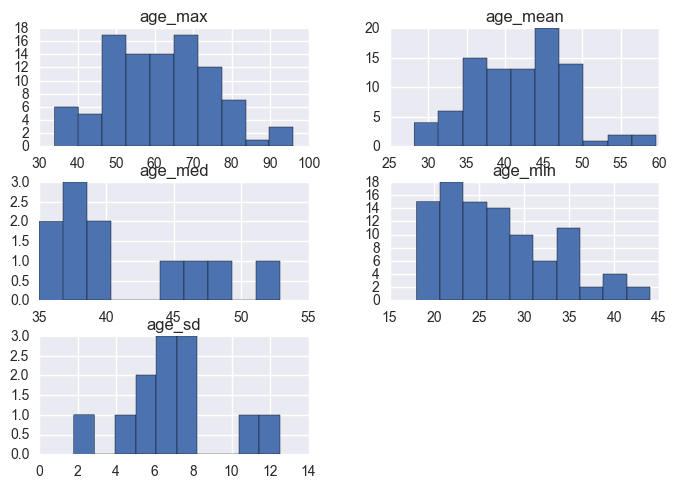

In [91]:
all_data[[c for c in all_data.columns if c.startswith('age')]].hist();

Breakdown on studies by design.

In [92]:
all_data.design.value_counts()

Retrospective    95
Prospective      40
RCT              27
Name: design, dtype: int64

Following [Pritts et al. (2015)](http://www.ncbi.nlm.nih.gov/pubmed/26283890), I fit a binomial random effects model, such that event probabilities on the logit scale are normally distributed with mean $\mu$ and standard deviation $\sigma$. This distribution describes how the probabilities vary across studies, with the degree of variation described by $\sigma$.

$$\theta_i \sim N(\mu, \sigma^2)$$

the expected value for study $i$ is then inverse-logit transformed, and used as the event probability $\pi_i$ in a binomial model describing the number of observed tumors $t$:

$$\log\left[\frac{\pi_i}{1-\pi_i}\right] = \theta_i$$

$$t_i \sim \text{Bin}(n_i, \pi_i)$$

There appears to be no obvious relationship between age (normalized) and tumor rate (though a quadratic model might be worth considering). We will not include age as a covariate in the model.

(0, 0.03)

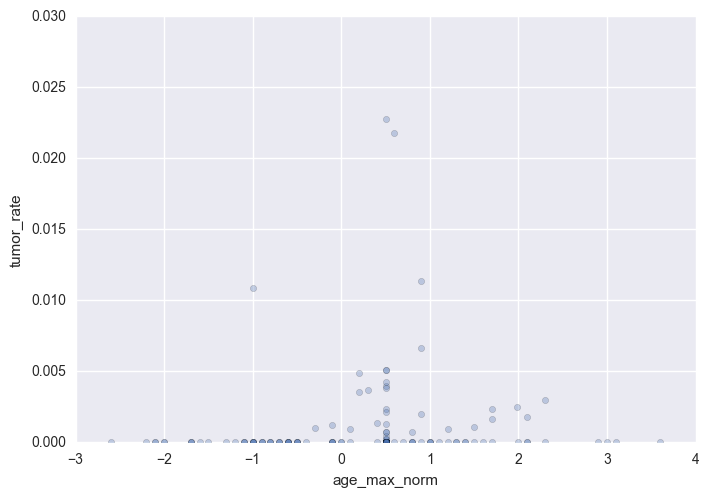

In [94]:
(all_data.assign(age_max_norm=((all_data.age_max - 60)/10).fillna(0.5), 
                 tumor_rate=all_data.Tumors/all_data.Population)
         .plot.scatter(x='age_max_norm', y='tumor_rate', style='ro', alpha=0.3)
         .set_ylim(0, 0.03))

In [95]:
import theano.tensor as tt
from numpy.ma import masked_values
invlogit = pm.math.invlogit

def create_model(model_data, x_cols=['Prospective']):
    
    with pm.Model() as model:

        k = model_data.shape[0]
        tumors = model_data.Tumors.values.astype(int)
        n = model_data.Population.values.astype(int)
        X = model_data[x_cols].values.astype(int)

        # Study random effect
        μ = pm.Normal('μ', 0, sd=100, testval=-3)
        σ = pm.Uniform('σ', 0, 1000, testval=10)
        θ = pm.Normal('θ', μ, sd=σ, shape=k)
        # Design effects
        β = pm.Normal('β', 0, sd=10, shape=len(x_cols))

        # Study-specific probabilities
        π = pm.Deterministic('π', invlogit(θ + β*X))

        # Expected probabilities by design
        p_retro_10000 = pm.Deterministic('p_retro_10000', invlogit(μ)*10000)
        p_prosp_10000 = pm.Deterministic('p_prosp_10000', invlogit(μ + β)*10000)

        obs = pm.Binomial('obs', n=n, p=π, observed=tumors)
        
    return model

##  Recapitulation of Pritts original  Meta-analysis

In [147]:
iterations = 10000
keep = 9000

In [140]:
pritts = create_model(old_pritts)

In [141]:
with pritts:
    pritts_trace = pm.sample(iterations, njobs=2, random_seed=[20140425, 19700903])

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -101.65: 100%|██████████| 200000/200000 [00:22<00:00, 8757.08it/s]
Finished [100%]: Average ELBO = -110.09
100%|██████████| 10000/10000 [00:53<00:00, 188.07it/s]


The following plots are the distribution of samples from the posterior distributions for the expected (population) probability of tumor (`p_update`), the inverse-logit expected probability ($\mu$) and the standard deviation of the probabilities on the inverse-logit scale ($\sigma$).

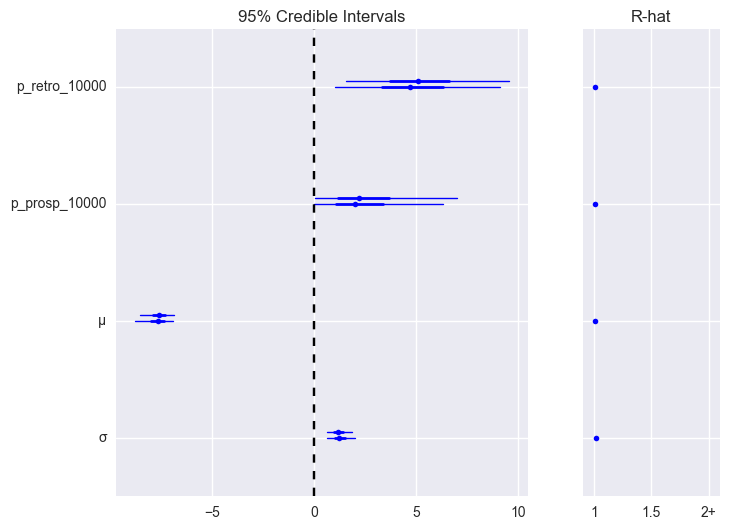

In [148]:
pm.forestplot(pritts_trace[-keep:], varnames=['p_retro_10000', 'p_prosp_10000', 'μ', 'σ']);

Summary statistics from each of the above parameters.

In [149]:
pm.summary(pritts_trace[-keep:], varnames=['p_retro_10000', 'p_prosp_10000', 'μ', 'σ'], roundto=4)


p_retro_10000:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.1157           2.1543           0.1119           [1.2762, 9.3829]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.5710         3.5416         4.9001         6.4873         9.8810


p_prosp_10000:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.6177           2.0627           0.0702           [0.0020, 6.6153]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.2621         1.1412         2.0978         3.5248         8.1295


μ:

  Mean             SD               MC Error         95% HPD interval
  -------

By comparison, estimates from Pritts' supplement:

![pritts estimates](pritts_table.png)

In [150]:
def pritts_plot(trace):
    
    p_vars = ['p_retro_10000', 'p_prosp_10000']
    intervals = [pm.stats.hpd(trace[var][-keep:]) for var in p_vars]

    meds = [np.median(trace[var][-keep:]) for var in p_vars]
    upper = [i[1] - m for m,i in zip(meds, intervals)]
    lower = [m - i[0] for m,i in zip(meds, intervals)]

    plt.errorbar(np.arange(2)-0.1, meds, yerr=[lower, upper], fmt='s', label='Updated MA')
    plt.errorbar(np.arange(2)+0.1, [5.7, 1.2], yerr=[[5.7-1.7, 1.2], [11.3 - 5.7,7.5 - 1.2]], 
                 color='r', fmt='D', label='Pritts MA', elinewidth=0.5)
    plt.xticks(range(3), ['Retrospective', 'Prospective'])
    plt.ylabel('Rate per 10,000 surgeries')
    plt.xlim(-0.5, 1.5)
    plt.legend();

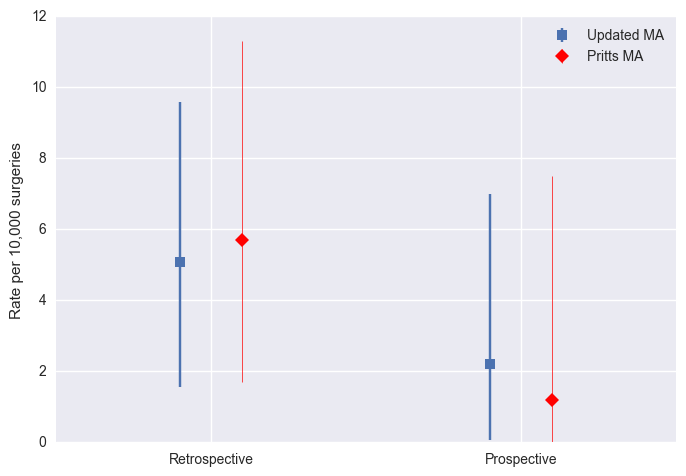

In [151]:
pritts_plot(pritts_trace)

## Pritts Update

In [120]:
pritts_new = create_model(updated_pritts)

In [121]:
with pritts_new:
    pritts_new_trace = pm.sample(iterations, random_seed=[20140425, 19700903][0])

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -102.67: 100%|██████████| 200000/200000 [00:24<00:00, 8230.89it/s]
Finished [100%]: Average ELBO = -110.22
100%|██████████| 5000/5000 [00:22<00:00, 222.03it/s]


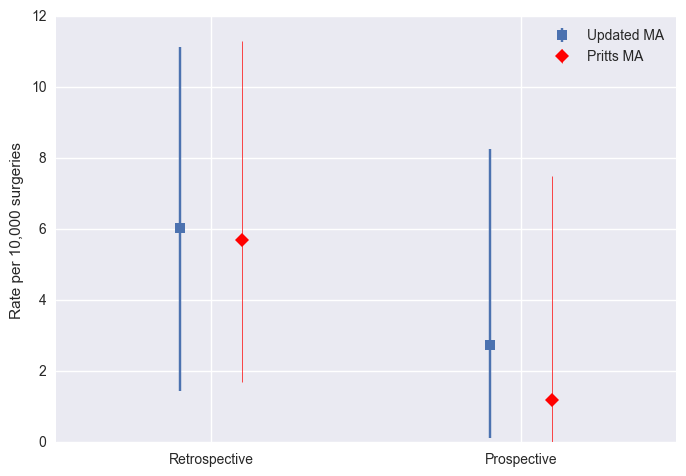

In [122]:
pritts_plot(pritts_new_trace)

## Pritts update with EPC includes

In [123]:
pritts_epc = create_model(all_data)

In [124]:
with pritts_epc:
    pritts_epc_trace = pm.sample(iterations, random_seed=[20140425, 19700903][0])

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -151.31: 100%|██████████| 200000/200000 [00:25<00:00, 7975.75it/s]
Finished [100%]: Average ELBO = -152.24
100%|██████████| 5000/5000 [00:18<00:00, 270.48it/s]


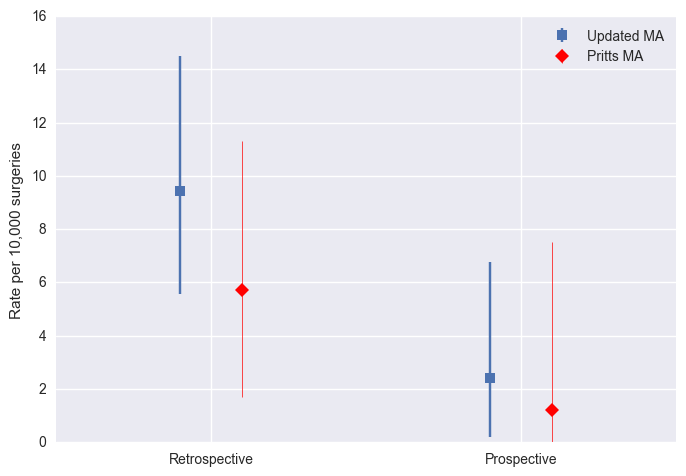

In [125]:
pritts_plot(pritts_epc_trace)

### Goodness of fit

To check how well the model fits the data, I conducted posteior predictive checks. This simulates data from the model for each data point (*i.e.* study) in the meta-analysis, and compares the distribution of these simulated values (here, 500 replicates) with the value of the data itself. If the percentile of the datum is very extreme (either large or small), then it is evidence that the model does not adequately fit the data. The distribution of percentiles in the bottom histogram shows that there is no evidence of lack of fit.

In [126]:
ppc = pm.sample_ppc(pritts_epc_trace, model=pritts_epc, samples=500)

100%|██████████| 500/500 [00:02<00:00, 217.76it/s]    | 1/500 [00:00<00:50,  9.85it/s]


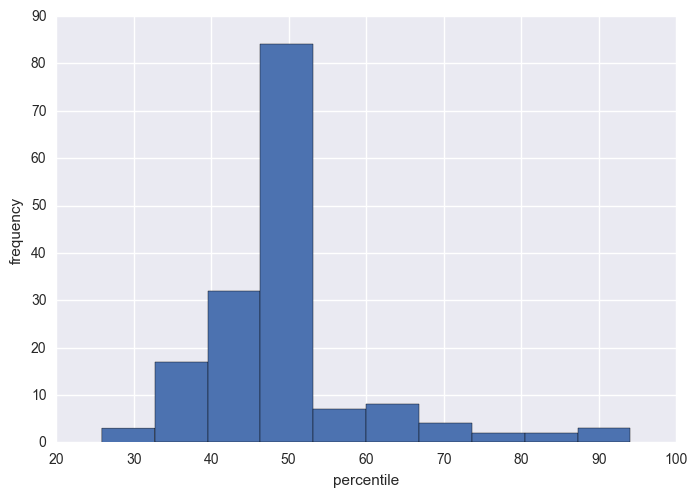

In [128]:
from scipy.stats import percentileofscore
        
p = [percentileofscore(s, o).round(2) for s,o in zip(ppc['obs'].T, all_data.Tumors)]
        
plt.hist(p)
plt.xlabel('percentile')
plt.ylabel('frequency');